In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(1, '../')
from genetic_selection import GeneticSelectionCV
from sklearn.tree import ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report, make_scorer
from sklearn.utils.validation import check_consistent_length

In [3]:
def eval(name, X_train, y_train, X_test, y_test):
    model = MLPClassifier(hidden_layer_sizes=(128,128), activation="relu", solver="adam",
                          learning_rate="adaptive", learning_rate_init=0.0003, 
                          batch_size=64, max_iter=300, 
                          early_stopping=True, n_iter_no_change=30)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    print(f"{name}")
    print("\nClassification report:\n")
    print(classification_report(y_test, y_preds))
    print("\nConfusion matrix:\n")
    print(confusion_matrix(y_test, y_preds))

    return (
        name,
        accuracy_score(y_test, y_preds)*100,
        precision_score(y_test, y_preds, average="weighted")*100,
        recall_score(y_test, y_preds, average="weighted")*100,
        f1_score(y_test, y_preds, average="weighted")*100       
    )

In [4]:
df_train = pd.read_csv('../UNSW-NB15/cleaned_data/UNSW_NB15_training-set_cleaned.csv')
df_validation = pd.read_csv('../UNSW-NB15/cleaned_data/UNSW_NB15_validation-set_cleaned.csv')
df_test = pd.read_csv('../UNSW-NB15/cleaned_data/UNSW_NB15_testing-set_cleaned.csv')
X_train, y_train = df_train.iloc[:, 0:-2], df_train.iloc[:, -2]
X_validation, y_validation = df_validation.iloc[:, 0:-2], df_validation.iloc[:, -2]
X_test, y_test = df_test.iloc[:, 0:-2], df_test.iloc[:, -2]

In [5]:
def custom_balanced_f1_score(y_true, y_pred):
    from sklearn.metrics import f1_score
    
    labels=[0,1,2,3,4,5]
    classwise_f1_scores = f1_score(y_true, y_pred, labels=labels, average=None)
    _score = 0
    for i in range(len(classwise_f1_scores)):
        _score += classwise_f1_scores[i]*(len(y_true)/sum([1 for y in y_true if y == i]))
    
    return _score

In [6]:
def genetic_selector(X_train, y_train, use_validation_set=False, X_validation=None, y_validation=None, verbose=0):
    selector = GeneticSelectionCV(
        estimator=ExtraTreeClassifier(), 
        scoring=make_scorer(custom_balanced_f1_score),
        n_population=120, 
        n_generations=100, 
        n_gen_no_change=12, 
        verbose=verbose,
        n_jobs=-1
        )
    selector.fit(X_train, y_train, use_validation_set=use_validation_set, valid_X=X_validation, valid_y=y_validation)
    print("no. of columns selected:")
    print(sum([1 for support in selector.support_ if support]))
    return selector

In [7]:
result_df = pd.DataFrame(columns=["name", "accuracy", "precison", "recall", "f1-score"])

In [8]:
validation_selector = genetic_selector(X_train, y_train, use_validation_set=True, X_validation=X_validation, y_validation=y_validation, verbose=1)

Selecting features with genetic algorithm.
gen	nevals	avg                               	std                               	min                            	max                                  
0  	120   	[ 32.176132  99.133333   0.      ]	[  9.338485  54.850544   0.      ]	[ 1.439379  3.        0.      ]	[  39.819664  194.          0.      ]
1  	64    	[  37.637175  121.258333    0.      ]	[  1.733622  44.652267   0.      ]	[ 30.86425  37.        0.     ]	[  40.109562  194.          0.      ]
2  	74    	[  38.248961  123.4         0.      ]	[  1.680211  46.581899   0.      ]	[ 25.299971  39.         0.      ]	[  41.186863  194.          0.      ]
3  	61    	[  38.815599  114.925       0.      ]	[  1.245974  48.879812   0.      ]	[ 32.29879  39.        0.     ]   	[  41.186863  194.          0.      ]
4  	73    	[ 39.237546  95.633333   0.      ]   	[  1.281809  41.358178   0.      ]	[ 35.436654  39.         0.      ]	[  41.776347  193.          0.      ]
5  	74    	[ 39.347179  75.65 

In [9]:
X_train_valid_selected = validation_selector.transform(X_train)
X_test_valid_selected = validation_selector.transform(X_test)
result_df.loc[len(result_df.index)] = [*eval("validation-genetic-selection", X_train_valid_selected, y_train, X_test_valid_selected, y_test)]

validation-genetic-selection

Classification report:

              precision    recall  f1-score   support

           0       0.35      0.06      0.10      2044
           1       0.56      0.92      0.70      5566
           2       0.41      0.39      0.40      3031
           3       1.00      0.95      0.98      9436
           4       0.95      0.87      0.91     18500
           5       0.62      0.77      0.69      1748

    accuracy                           0.81     40325
   macro avg       0.65      0.66      0.63     40325
weighted avg       0.82      0.81      0.81     40325


Confusion matrix:

[[  113  1801    43     0    33    54]
 [   97  5115    88     2   143   121]
 [   24   986  1195     0   559   267]
 [   17   288    23  8998    16    94]
 [   75   529  1541     3 16066   286]
 [    1   349     8     0    39  1351]]


In [10]:
import seaborn as sb

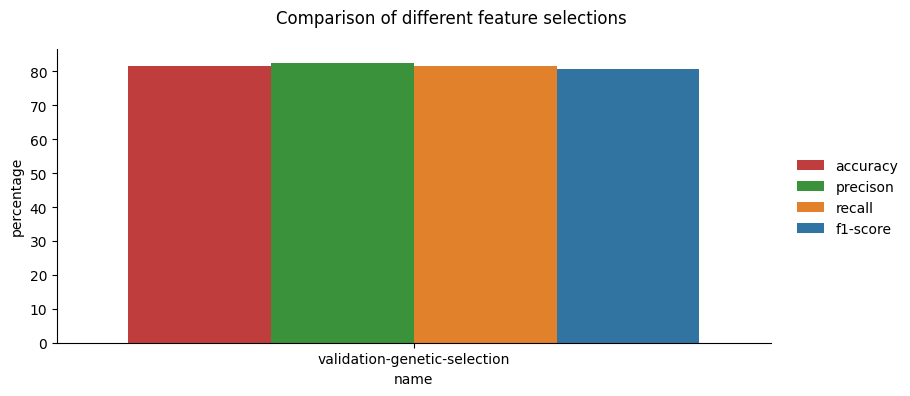

In [11]:
result_dfm = pd.melt(result_df, id_vars=("name"), value_vars=("accuracy", "precison", "recall", "f1-score"), var_name="metric", value_name="percentage")
g = sb.FacetGrid(result_dfm, height=4, aspect=2, )
g.map_dataframe(sb.barplot, data=result_dfm, x="name", y="percentage", hue="metric", palette=["tab:red", "tab:green", "tab:orange", "tab:blue"])
g.fig.suptitle("Comparison of different feature selections")
g.add_legend()
g.tight_layout()

In [12]:
result_df

,name,accuracy,precison,recall,f1-score
0,validation-genetic-selection,81.433354,82.445825,81.433354,80.680708
